Parameters used in the code:

N: Number of sites in the transverse field Ising model.

This code optimizes only 8 sites because we are using SciPy with a CPU, which is slow but suitable for a toy model.

B: B-field value for the target Hamiltonian, which can be zero or non-zero.

J_value: J coupling strength.

J_matrix_alpha: Power-law decay constant.

x: the best field used in modulated time evolution, the first half is $\lambda (t)$ while the second half is $B(t)$

number_of_layers: The number of steps in the modulated time evolution.

m: the error ratio when translating MTE to QAOA. It can be adjusted at the end of the code to modify the number of layers in QAOA.

final output file name is, f'scipy_QAOA_result_N={N}_B={B}_layers_{len(flattened_new_x_A_list)}.txt'


In [1]:
import numpy as np
# initialize variables
N = 8
B = 0.1    
J_value = 1
J_matrix_alpha = 1
x = np.array([0.481648640320813, 0.6392949356754583, 0.4649781516823971, 0.6518475128577886, 0.7955844634336527, 0.9787585633033431, 2.01698576701233, 2.841485170761013, 1.452539894644007, 1.2302090688738114, 7.418158051701331, 3.0226608991375126, 1.3673757532433595, 0.7605554646391439, 0.5852122130608153, 0.504743518139635, 0.43352984765388014, 0.3706165784075941, 0.27863901585784, 0.1851910325406766 ])
number_of_layers=len(x)//2
print('number of layers in MTE is',number_of_layers)
#######################################################'
# example use here is the case where we trotter a 10 layers MTE to 30,40 or 50 layers QAOA

number of layers in MTE is 10


In [2]:
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
np.set_printoptions(precision=6)
# Q is the dimension
Q = pow(2, N)
# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)



In [3]:
def get_energy(H_matrix,state):

    a = np.dot(H_matrix,state)
    energy = np.dot(np.conjugate(state),a).real

    return energy

def get_fidelity(gs,state):

    dp = np.dot(gs,state) # dp is dot product
    #print(dp)
    dp_cc = np.conjugate(dp)     # the complex conjucate of the dot product
    return (dp*dp_cc).real



In [4]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis

for n in range(Q):  # n is an unused index

    # couple_num_list would be my result for each state we loop

    if len(loop_state_list)!=0: # loop for couple number for one state

        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)

        for m in range(Q): # loop for spin and spatial for all states inside the couple number list

            if m==0:

                couple_num_list_old =couple_num_list

                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # spatial reflection
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)

                    # remove the repeated element
                    couple_num_list = np.unique(couple_num_list)
            else:

                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first
                    couple_num_list_old =couple_num_list

                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)


                        # spatial reflection
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)

                        # remove the repeated element
                        couple_num_list = np.unique(couple_num_list)

        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())

        # remove the ones already found
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))




In [5]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

In [6]:
# loop each basis to fill in the diagonal elements for HA matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # loop each element inside the array
    normalization = len(state_array)

    # energy total for all the product states inside one basis

    e_tot = 0
    for j in range(len(state_array)):

        state = D2B(state_array[j])

        # loop over N sites to change the state vector to either 1 or -1

        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs

        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

In [7]:
# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))

    for j in state_array:
        vector_form_basis_matrix[i][j] = 1

    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization



In [8]:
# loop each basis to fill in HB matrix

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):

        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0


    # generate the vector form for the state after operrator acting on it

    vector_final_state = np.zeros(Q)

    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1

    # put back normalization factor
    vector_final_state = vector_final_state/normalization

    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):

        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [9]:
# get true ground state
w, v = LA.eigh(HA_matrix + B* HB_matrix)
inx = np.argsort(w)
true_gs_vec = v[:, inx[0]]
E_max = w[-1]
gs_energy =w[0]

In [10]:
# get ground state with just H_B 
w, v = LA.eigh(HB_matrix)
inx = np.argsort(w)
temp_vec = v[:, inx[0]] # the index here could be zero or one, depending on the parity
# but if the wrong index will always give roughly zero fidelity

In [11]:
# get initial fidelity
fidelity_t_0 = get_fidelity(temp_vec,true_gs_vec)
print('fidelity before optim is', fidelity_t_0)

fidelity before optim is 0.016242148889510737


In [12]:
target_H = np.copy(HA_matrix + B* HB_matrix)

The following cell computes the energy and fidelity using the input x in MTE form, serving as a check to ensure the input is correct.

In [13]:
def lambda_evolve(x_A,x_B):
    # x_A = x[:number_of_layers]
    # x_B = x[number_of_layers:]
    global fidelity

    # final_fidelity_list =[]
    # final_fidelity_list.append(fidelity_t_0)

    # product state
    p = temp_vec  # p stands for product

     # loop each time step
    for i in range(number_of_layers):

        H_matrix = x_A[i]*HA_matrix + x_B[i]*HB_matrix
        exp_imgH_matrix = expm( 1*1j*H_matrix )
        new_p = np.dot(exp_imgH_matrix,p)
        # update state
        p = new_p

        # get fidelity
        #fidelity = get_fidelity(true_gs_vec,p)
        # print('fidelity is ',fidelity)
        # get energy
        energy = get_energy(target_H,p)

    fidelity = get_fidelity(true_gs_vec,p)
    #print(energy)
    #return -1*fidelity
    return energy
    
########################################################
x_A = x[:number_of_layers]

x_B = x[number_of_layers:]*x_A

print('energy is',lambda_evolve(x_A,x_B))
print('fidelity is',fidelity)
########################################################

energy is -5.09253144812376
fidelity is 0.9907158367082259


In [14]:
def lambda_evolve_qaoa_for_optim(x): 
    location =(len(x)//2+1)
    x_A = x[:location]
    x_B = x[location:]
    #print(x_A,x_B)
    global fidelity

    # final_fidelity_list =[]
    # final_fidelity_list.append(fidelity_t_0)

    # product state
    p = temp_vec  # p stands for product

     # loop each time step
    number_of_layers = len(x_B)
    if len(x_A) == len(x_B):
        
        for i in range(number_of_layers):


            exp_imgHA_matrix = expm( HA_matrix * 1j * x_A[i])
            exp_imgHB_matrix = expm( HB_matrix * 1j * x_B[i])
            #print(x[i],x[i+number_of_layers])

            H_eff = exp_imgHB_matrix @ exp_imgHA_matrix
            new_p = np.dot(H_eff,p)
            # update state
            p = new_p
            
    else:
        
        for i in range(number_of_layers):
            exp_imgHA_matrix = expm( HA_matrix * 1j * x_A[i])
            exp_imgHB_matrix = expm( HB_matrix * 1j * x_B[i])
            #print(x[i],x[i+number_of_layers])

            H_eff = exp_imgHB_matrix @ exp_imgHA_matrix
            new_p = np.dot(H_eff,p)
            # update state
            p = new_p
            
        ## the extra x_A
        
        exp_imgHA_matrix = expm( HA_matrix * 1j * x_A[-1])
        new_p = np.dot(exp_imgHA_matrix,p)
        # update state
        p = new_p
            
    energy = get_energy(target_H,p)
    fidelity = get_fidelity(true_gs_vec,p)
    #print(fidelity)
    return energy

The following data is from " Quantum Approximate Optimization of the Long-Range Ising Model with a Trapped-Ion Quantum Simulator " (https://doi.org/10.1073/pnas.2006373117). 

This QAOA calculation is used to verify that the code is functioning correctly and for comparison purposes
"

In [15]:
def lambda_evolve_qaoa_even(x): 
    location =(len(x)//2)
    x_A = x[:location]
    x_B = x[location:]
    global fidelity

    # product state
    p = temp_vec  # p stands for product
     # loop each time step
    number_of_layers = len(x_B)
    for i in range(number_of_layers):
        exp_imgHA_matrix = expm( HA_matrix * 1j * x_A[i])
        exp_imgHB_matrix = expm( HB_matrix * 1j * x_B[i])
        #print(x[i],x[i+number_of_layers])

        H_eff = exp_imgHB_matrix @ exp_imgHA_matrix
        new_p = np.dot(H_eff,p)
        # update state
        p = new_p
            
    energy = get_energy(target_H,p)
    fidelity = get_fidelity(true_gs_vec,p)
    print('fidelity is',fidelity)
    print('energy is',energy)

In [16]:
## umd data
########################################################
x_umd= np.array([0.087237, 0.194123, 0.226874, 0.334604, 0.377018, 0.291042,
       0.344082, 0.421822, 0.285563, 0.388708, 0.502747, 0.434695,
       0.256231, 0.503005, 0.569938, 0.591628, 0.605003, 0.598513,
       0.608654, 0.633627, 0.631977, 0.637611, 0.649737, 0.676677,
       0.676464, 0.696663, 0.67259 , 0.669361, 0.687002, 0.692227,0.554162, 0.361565, 0.344897, 0.353104, 0.276663, 0.196081,
       0.264926, 0.231466, 0.164323, 0.265755, 0.260146, 0.146398,
       0.189163, 0.266257, 0.27309 , 0.265409, 0.260555, 0.257791,
       0.262728, 0.252066, 0.238607, 0.229575, 0.210981, 0.20255 ,
       0.183635, 0.173964, 0.136015, 0.127602, 0.1123  , 0.057738])
########################################################

# Because QAOA angles in this work has an extra exp( HA_matrix * 1j * theta) factor, calculate QAOA angles in umd work need to use lambda_evolve_qaoa_even fucntion 
lambda_evolve_qaoa_even(x_umd)

fidelity is 0.9966767042784
energy is -5.091138724905807


In [17]:
def get_expand_amps(gamma,beta,layers):
    
    if layers ==1:
        gamma_series = np.array([gamma/2,gamma/2])
        beta_series = np.array([beta])
        
    else:
        gamma_series = np.ones(layers-1)*(gamma/layers)
        # Add an element to the first index
        gamma_series = np.insert(gamma_series,0,(gamma/(2*layers)))
        gamma_series = np.insert(gamma_series,len(gamma_series),(gamma/(2*layers)))
        
        beta_series = np.ones(layers)*(beta/layers) # plus one for the first one 
    
    return gamma_series,beta_series

In [18]:
def find_m(a, b, max_ratio):
    
    a = np.abs(a)
    b =np.abs(b)
    
    # Start with an initial value for m
    m = 1
    
    # Define a function to calculate the ratio (a/m + b/m) / (a+b)
    def ratio_function_1(m):
        return ( (a*a*b)/(24*m*m) ) / (a + b)
    
    def ratio_function_2(m):
        return ( (a*b*b)/(12*m*m) ) / (a + b)

    for m in range(1,200):
        
        if ratio_function_2(m)<max_ratio and ratio_function_1(m)<max_ratio:
            #print(ratio_function_1(m),ratio_function_2(m))
            best_m = m
            break
    return best_m


Here, we input a m value , details are in 
https://doi.org/10.48550/arXiv.2408.03251 supplemental file 

- m value for number of QAOA layers
- 0.0055 for 31 layers,
- 0.003 for 40 layers,
- 0.0018 for 50 layers, 
- 0.0012 for 60 layers,
- 0.00062 for 80 layers
- 0.000394 for 100 layers.s.

In [19]:
# get p_list from ratio
p_list =[]
for i in range(len(x_A)):
    p = find_m(x_A[i], x_B[i], 0.0055)  # INPUT M VALUE HERE
    p_list.append(p) 

In [20]:
# In this context, the p list indicates how many QAOA layers correspond to each MTE layer. 
#For example, the mapping is 1 to 5 layers in the frist case and  1 to 4 layers in the second case.
p_list

[5, 4, 2, 2, 2, 2, 4, 5, 2, 2]

In [21]:
from itertools import chain
# get qaoa like input
new_x_A_list =[]
new_x_B_list =[]
for i in range(len(x_A)):
    gamma = x_A[i]
    beta = x_B[i]
    index_of_power = p_list[i]
    #print(index_of_power)
    new_x_A,new_x_B = get_expand_amps(gamma,beta,index_of_power)
    
    # append result
    new_x_A_list.append(new_x_A)
    new_x_B_list.append(new_x_B)

#new_x_A_list = list(chain.from_iterable(new_x_A_list))
new_x_B_list = list(chain.from_iterable(new_x_B_list))


flattened_new_x_A_list = []

for i, sublist in enumerate(new_x_A_list):
    if i > 0:
        flattened_new_x_A_list[-1] = flattened_new_x_A_list[-1] + sublist[0]
        flattened_new_x_A_list.extend(sublist[1:])
    else:
        flattened_new_x_A_list.extend(sublist)


In [22]:
# this is the inital guess for QAOA optim from MTE
x = np.concatenate((flattened_new_x_A_list,new_x_B_list))

In [23]:
print('number of QAOA layers is',len(flattened_new_x_A_list))

number of QAOA layers is 31


In [24]:
Nfeval = 1
filename = f'scipy_QAOA_training_log_N={N}_B={B}_layers_{len(flattened_new_x_A_list)}.txt'
energy_list = []

def callback(intermediate_result):
    global Nfeval
    global energy_list
    energy =intermediate_result.fun
    energy_list.append(energy)

    # Print information
    print(f'{Nfeval:4d}   Energy: {energy:.6f}')
    
    # Write information to a file
    with open(filename, 'a') as f:
        f.write(f'{energy:.6f},')
    
    Nfeval += 1

In [32]:
# Execute the following line to run the optimization.
###########################################
result = scipy.optimize.minimize(lambda_evolve_qaoa_for_optim,x,method='BFGS',callback=callback,options={'gtol': 1e-5})

In [ ]:
result_filename = f'scipy_QAOA_result_N={N}_B={B}_layers_{len(flattened_new_x_A_list)}.txt'

# Function to save the result into a file
def save_result_to_file(result, filename):
    with open(filename, 'w') as f:
        f.write(f"message: {result.message}\n")
        f.write(f"success: {result.success}\n")
        f.write(f"status: {result.status}\n")
        f.write(f"fun: {result.fun}\n")
        f.write(f"x: {result.x.tolist()}\n")
        f.write(f"nit: {result.nit}\n")
        f.write(f"jac: {result.jac.tolist()}\n")
        f.write(f"hess_inv: {result.hess_inv.tolist()}\n")
        f.write(f"nfev: {result.nfev}\n")
        f.write(f"njev: {result.njev}\n")

# Save the result
save_result_to_file(result,result_filename)

In [25]:
# Example usage based on previously optimized data.
best_x_30 =np.array( [0.0936603564367677, 0.2051762001214427, 0.2463089094873932, 0.3901184422577069, -0.1566552695202834, 0.0952731242017399, 0.4823711229952712, 0.3229252099663475, -0.2894891838278786, 0.2446330166267743, 0.4091517928591440, 0.3411597524344765, 0.3767487235601615, 0.4096550299124064, 0.4360496642978115, 0.4406235887278616, 0.4510140521581578, 0.4562368196353694, 0.4700707130769085, 0.4851953143658400, 0.4751266474409635, 0.4587435694048260, 0.4484821150875642, 0.4706320058835329, 0.5032829673048763, 0.5531659862137859, 0.5902255542443087, 0.6063080390406458, 0.7405262870253992, 0.9533213780481534, -1.5217628565839387, 0.5229050589704566, 1.9274298721988705, 0.2749883070349547, 1.0406904148110370, 0.1010325783319367, 0.8281348694198741, 0.1540480924718009, 1.2098262607889863, 0.0524561782550547, 0.5956815851714431, 0.1799565723772132, 0.1895626101278335, 0.1970029573300717, 0.2071430427837794, 0.2010495184863038, 0.1963274483645235, 0.1948801434805197, 0.1993824098776083, 0.2023461969345260, 0.1942961329180070, 0.1772497714992665, 0.1680109352275089, 0.1719426437094280, 0.1818287948352202, 0.1802819305886998, 0.1725549275552033, 0.1578787108300562, 0.1319753198628043, 0.0776464838585328, 0.0384578846102251                   ])
best_x_40 = np.array([0.10171197978282819, 0.23452263551077265, 0.2952944661308091, 0.40385027514921074, 0.130342711921415, -0.14192665294318357, 0.0009319262241798356, 0.17465933035710773, 0.30328653708132747, 0.022175513479698896, -0.16381688925989615, 0.14714399515098756, 0.24646436585398665, 0.27225338663953536, 0.18171896629196949, 0.24254101578830498, 0.22648926354028687, 0.371302473440885, 0.41229610464063765, 0.4322392645866204, 0.4602484919360992, 0.46620704718060835, 0.46119266357261457, 0.4649399002898082, 0.4770361823649284, 0.14396855569152361, 0.26491041359521494, 0.48578830024662717, 0.5009502419692582, 0.4968982486411721, 0.4096111073480211, 0.4200095671459159, 0.5343891503746732, 0.5931448563835003, 0.6259242735938608, 0.651564460480234, 0.6621492143444425, 0.6469747883356498, 0.6265284901100269, -7.468275816880233e-05, 0.5574354751967595, 0.41534558872731425, 0.33550363262275934, 0.36568469716398294, 1.0029423964087087, 0.14332399868351758, 0.08352346859052899, 0.41382448962304436, 0.6321751394720654, 0.6108124435012142, 0.19213210851960102, 0.4089521907521196, 0.13342546686202736, 0.13038153395228733, 0.12597696249633739, 0.11133388641379938, 0.16646075029552349, 0.20537932939067066, 0.2072085211817601, 0.21256510098138862, 0.21464938181866655, 0.20655477846183423, 0.20136535685740226, 0.1983675760093686, 0.2526658774768438, -0.10612464240174381, 0.2199151701037883, 0.19689528554217342, 0.19740107294634043, 0.16877635703005778, 0.13147520846091537, 0.15941073016627902, 0.1769598762144772, 0.17281720170426598, 0.15968149727658423, 0.13944710014386455, 0.12225148380809951, 0.10126538918195123, 0.050545854158937385])
best_x_50 = np.array([0.0647514601591052, 0.166394162798547, 0.23885485178177834, 0.2977756720036629, 0.3171800000402093, 0.317166918392768, 0.05006511042372438, -0.10688439902826523, 0.03267311162764664, 0.13138043563285215, 0.27608374845393663, 0.07356910175871981, 0.052182695467071404, -0.0449525161461456, 0.04198885454358715, -0.11726646539205779, 0.2405284379426732, 0.18941293127690878, 0.1387646575258391, 0.40865359647160937, 0.3779846647216628, 0.37529116928772227, 0.4144323733220048, 0.33372257996210575, 0.32150891797881903, 0.434124463500779, 0.40054997132402764, 0.33096603116478807, 0.12273102762645025, 0.4257643960860163, 0.48521023128211, 0.44952743155821606, 0.4124433224159519, 0.4283018118365142, 0.4259419374351622, 0.26513183842370797, 0.33980724480110364, 0.4817507239408005, 0.4276029813202166, 0.336890397121883, 0.5253984858056244, 0.6077905149020423, 0.6371120063976905, 0.650904065732478, 0.6603734261841776, 0.6656661168414477, 0.6609086600094088, 0.6360416306833484, 0.7384115567156863, -0.44648590649258657, 0.5811476104640556, 0.4429248974328886, 0.37977372162011896, 0.32836383057161855, 0.262135243565093, 0.5179785734016681, 0.15336538195732807, 0.22439769856744937, 1.0236263551767855, -0.09846438150531468, 0.32963401369110473, -0.20887845804063954, 0.4925351181910959, 0.6406315513599943, 0.2612397663096956, 0.287050914640353, 0.2322524134465559, -0.09683176112448078, 0.2793532813014199, 0.2277342393071619, 0.19570045326936453, 0.20589853129879387, 0.19730044879530928, 0.1347117671465006, 0.18768287964585437, 0.19856202232227085, 0.1621522384708093, 0.09000564675852356, 0.11376002225669386, 0.20262229995625822, 0.1976416244474579, 0.17306117228923742, 0.16572085261048386, 0.1676880410401238, 0.14160388671238536, 0.07927393829958533, 0.1564703026645255, 0.159617761756837, 0.10626419107039968, 0.12847612388008217, 0.1634510900549965, 0.16546790380043963, 0.15903652531503187, 0.1487628435618338, 0.13640592803122942, 0.12057432995991971, 0.10455827677828057, 0.08112377580490084, 0.01368310839293342])
best_x_60 =np.array( [0.0609189168862844, 0.1519214777441040, 0.2177415558803502, 0.2775193392884092, 0.3148216564476874, 0.3233111475294995, 0.1875038654151858, 0.0802059993046237, -0.0722005506934682, -0.0109992027318399, 0.1034454299434343, 0.2126645985165376, 0.1502326581335771, -0.0385744412036069, 0.0563074777331458, 0.0274769434471584, 0.1441146488276454, -0.0990232575527071, -0.0763582677431228, -0.0805861001932164, 0.4376096923205982, 0.0102732749443041, 0.3675225437702748, 0.0077309900566174, 0.3961507922020510, 0.4303347067657325, 0.4153958775139957, 0.3959655950139763, 0.3731580896306516, 0.1688493608470218, 0.0329773079660679, 0.3615461136263413, 0.2265199481217018, 0.3456313725681977, 0.4466686698126207, -0.1362958751404506, 0.1975086207421070, 0.2263939347861471, 0.1215174798477647, 0.4351273407165654, 0.4826779708629020, 0.5028489299117584, 0.4789525803862550, 0.3940024499136431, 0.4156170770179988, 0.5034729451142987, 0.3321173102325121, 0.2885091048543854, 0.5634063294709696, 0.4849027111137416, 0.1583340293792161, 0.5878695911352591, 0.6186049717051209, 0.6312562827934277, 0.6379517184737654, 0.6447879540097436, 0.6414871922308933, 0.6141203929569636, 0.7006991994543212, -0.4465979198001656, 0.5791193829417574, 0.4453380939813435, 0.3874578645914323, 0.3444996985468358, 0.3038575339719551, 0.2631731332415791, 1.0984050827391902, -0.0795498995011945, 0.3087893298063697, 0.1912233691977209, 0.3194203215179484, -0.2155506234398110, 0.4467787396091157, -0.6239973840523872, 0.0298806595169625, 1.2181757475500294, -0.0188769942126243, 0.1837741170896478, 0.1701580609038909, 0.5684514934605466, 0.3200375380088773, -0.0838440008214065, 0.3949919193676327, -0.1660981668713009, 0.2386447734958723, 0.2269210363419732, 0.2042222212119692, 0.1934671490225616, 0.1447105675560622, -0.0648493313572199, 0.1777572668716369, 0.1561655658629411, 0.0963838146275836, 0.1854511568567686, 0.0449256855580622, 0.0409098983677676, 0.1304070590594006, -0.0502732788478662, 0.2000656805526236, 0.1922185462097727, 0.2031341807570012, 0.1973452629285435, 0.1680356376573205, 0.1374432203433954, 0.1655656761424308, 0.1678715627658535, 0.0427045192878163, 0.1597659230236304, 0.1662670312688279, 0.0429169407729353, 0.1302722050512265, 0.1549782709696887, 0.1480778858806875, 0.1369344092373340, 0.1236394515539423, 0.1084908104755546, 0.0938411519505762, 0.0701163530541828, 0.0092803998512390])
best_x_80 = np.array([-0.0424810948602934, 0.1026983223523859, -0.0398203507203160, 0.0836624294244694, 0.0293409698141539, 0.0692511547390258, 0.1359321274655585, 0.0337479959657929, 0.0313542517954505, -0.0160107978823175, -0.0038296421875186, -0.0251281392154148, 0.0335188620280699, 0.0255951456872216, 0.0323774603054501, 0.0879004579308568, 0.0317613280137807, 0.0397191651820374, -0.0062877337211761, 0.0129321069890765, -0.0083762262934412, -0.0030142610156823, 0.0002009346621893, -0.0098269153182629, 0.0440232219966633, 0.0714799780396456, 0.0404802514388464, 0.2076326889114722, 0.2196177798717421, 0.2000022151128549, 0.1852012481406474, 0.1756013666278461, 0.2325435730643387, 0.2486271327096015, 0.2801867104213627, 0.2803683500401855, 0.2767868403404265, 0.2849349778280637, 0.2786451424271765, 0.2884720286868525, 0.2641904821853455, 0.2531488321351231, 0.2566299974546563, 0.2037140733560354, 0.2328532284709324, 0.2350035229940139, 0.1765730371597180, 0.2358295330106763, 0.2653149982296147, 0.2578171220023170, 0.3016246882468108, 0.3262253226243042, 0.3421577962144998, 0.3543674968676780, 0.3571845087432406, 0.3457550467087496, 0.3284676569104938, 0.3262328568620657, 0.2878917507213414, 0.2988148592562949, 0.3189415766323391, 0.2893447993254001, 0.3648238896003053, 0.3832776346362605, 0.3776656045480822, 0.3630740028520964, 0.3658649791173486, 0.3642662009535073, 0.3675156559185244, 0.4163574952479840, 0.4532761822312315, 0.4779679829553732, 0.4761104618726156, 0.4270503630334642, 0.4312346406518344, 0.4875343124179262, 0.4820215299411769, 0.4426394496195690, 0.4428076503736208, 0.3739830573751433, -0.0648600844637029, 0.0175641643753809, 0.2214662995623984, 0.2765745745375634, 0.2000794534124461, 0.2204223487278709, 0.2599260811950088, 0.2707747814430673, 0.2778764780442392, 0.2978668036750617, 0.3298314847318548, 0.2340864076625876, 0.2091803386239040, 0.1339610963473810, 0.2051072717132403, 0.1045927062259071, 0.0905710645359705, 0.1364647912890238, 0.1959662046276549, 0.2456281696405663, 0.2226763094302379, 0.2523416253527972, 0.1898406131440128, 0.1582196093852772, 0.1206408015244746, 0.1309849408022672, 0.1719918871154317, 0.0903176903577139, 0.2332607512748363, 0.1830926161061901, 0.1692165205246689, 0.1217904221639259, 0.1575235755080769, 0.1622012534462155, 0.1732579040934091, 0.1751289527393548, 0.1624752314826566, 0.1597082069042098, 0.1539202257814358, 0.1489885928594471, 0.1457790292606851, 0.1232788476859944, 0.1292244504781225, 0.1088648133478620, 0.0974302094382964, 0.1140190303946814, 0.0923122792585590, 0.0851280129082342, 0.1179625449624150, 0.1104569842362780, 0.1197464229698605, 0.1341276915423285, 0.1393231279712631, 0.1432866509490482, 0.1441125715378980, 0.1397419942351713, 0.1295410986642254, 0.1228411823047366, 0.1154256417860978, 0.0971182244592765, 0.1136793852547967, 0.0966088037732524, 0.1061858764183808, 0.1193293312634662, 0.1135635880330005, 0.1056784916077666, 0.0978770797464761, 0.0963946701077432, 0.0891137592534112, 0.0932726328190429, 0.0992259905968961, 0.0995492556451432, 0.0953359083769773, 0.0824899756378670, 0.0685866033239505, 0.0714994327194024, 0.0694346127887010, 0.0590905468096387, 0.0518278227376197, 0.0479021135668921, 0.0122408262598471])

In [33]:
# 30 and 80 layers can also be considered as 31 and 81 layers since they both have one additional factor
# the rest has one less factor 
print('energy afater optim in QAOA form is ', lambda_evolve_qaoa_for_optim(best_x_30) )

energy afater optim in QAOA form is  -5.1056068473820435


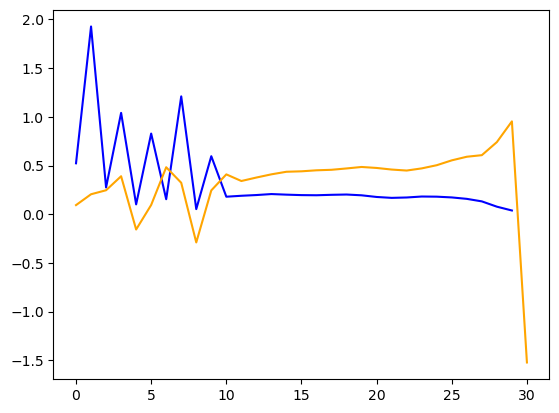

In [37]:
# plot the two angle curves
best_qaoa =best_x_30
location =(len(best_qaoa)//2+1)
best_gamma = best_qaoa[:location]
best_beta = best_qaoa[location:]
plt.plot(best_beta,color='blue')
plt.plot(best_gamma,color='orange')